In [11]:
import os
import openai
import random
import urllib.request
import ipywidgets as widgets
import matplotlib.pyplot as plt
import Augmentor as aug
import shutil
import yaml
import fnmatch
from PIL import Image, ImageDraw

# Load your API key from an environment variable or secret management service
openai.api_key = os.getenv("OPENAI_API_KEY")

# Constants

In [12]:
BACKGROUND_PATH = "backgrounds/"
IMAGE_PATH = "dataset/train/images"
LABEL_PATH = "dataset/train/labels"
TRAFFIC_SIGN_PATH = "traffic_signs_only"
TEMP_PATH = "temp"

# Generate Images

In [13]:
# create a slider for the number of images to generate
slider = widgets.IntSlider(min=0, max=100, step=1, value=10, description='Number of images to generate:')
display(slider)

IntSlider(value=10, description='Number of images to generate:')

Generated background image with road type 'A photograph of a highway with traffic and pedestrians and construction and road works from drivers perspective.':


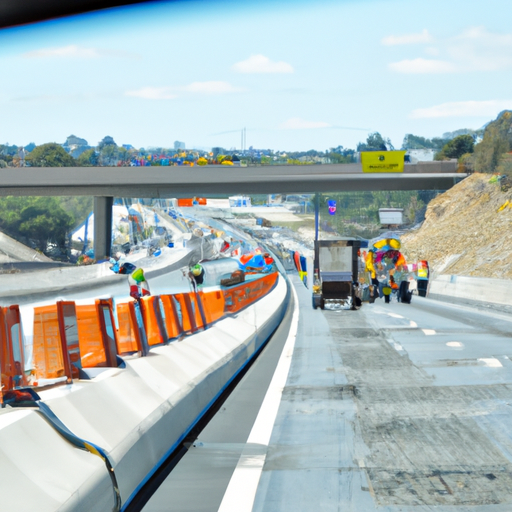

Initialised with 3 image(s) found.
Output directory set to temp\output.

Processing <PIL.Image.Image image mode=RGBA size=52x52 at 0x250DD783388>: 100%|██████████| 3/3 [00:00<00:00, 249.99 Samples/s]

Generated image with traffic signs:


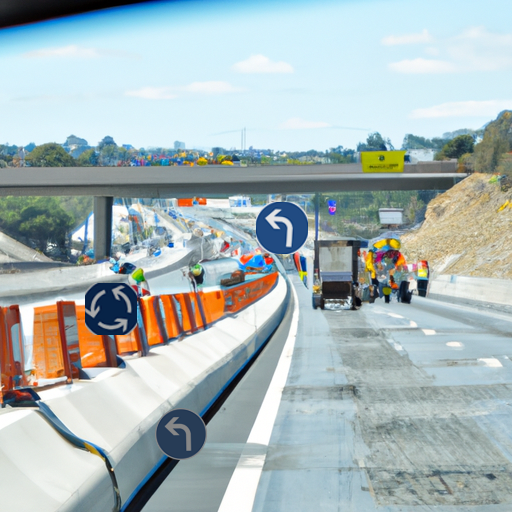

Generated image with bounding boxes:


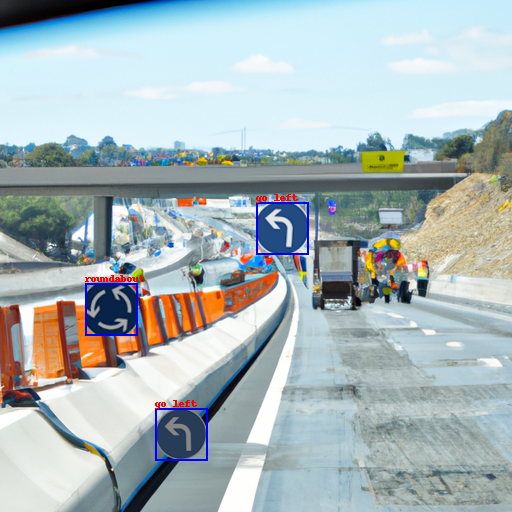

In [20]:
# create dataset directory if it doesn't exist
if not os.path.exists(IMAGE_PATH):
    os.makedirs(IMAGE_PATH)
if not os.path.exists(LABEL_PATH):
    os.makedirs(LABEL_PATH)
# Open the YAML file and read the data
with open("data.yaml", "r") as file:
    data = yaml.safe_load(file)
# get class names to list
class_names = data['names']
# create a dictionary to save the positions of the traffic sign images on the background image
traffic_sign_positions = {}
# create for loop for the number of images to generate
for i in range(slider.value):
    # remove temporary directory
    if os.path.exists(TEMP_PATH):
        shutil.rmtree(TEMP_PATH)
    # a list of different types of roads in different environments 
    road_types = ["highway", "highway with traffic", "highway with traffic and pedestrians", "highway with traffic and pedestrians and construction", "highway with traffic and pedestrians and construction and road works", "autobahn", "street", "street with traffic", "street with pedestrians"]
    # use DALL-E to generate a background image environment that usually contain traffic signs
    random_road_type = f"A photograph of a {road_types[random.randint(0, len(road_types)-1)]} from drivers perspective."
    response = openai.Image.create(
        prompt=random_road_type,
        n=1,
        size="512x512"
    )
    image_url = response["data"][0]["url"]
    # get amount of images in background directory
    amount_background_images = len(os.listdir(BACKGROUND_PATH))
    # download the image to and save it to the background directory
    urllib.request.urlretrieve(image_url, f"{BACKGROUND_PATH}/background_{amount_background_images}.png")
    # open the image with PIL
    pil_image = Image.open(f"{BACKGROUND_PATH}/background_{amount_background_images}.png")
    # show pil image in notebook
    print(f"Generated background image with road type '{random_road_type}':")
    display(pil_image)
    # get 1-4 random images from the traffic sings only directory
    random_images = random.sample(os.listdir(TRAFFIC_SIGN_PATH), random.randint(1, 4))
    # create temporary directory for the traffic sign images
    if not os.path.exists(TEMP_PATH):
        os.mkdir(TEMP_PATH)

    # copy images to temp directory
    for image in random_images:
        shutil.copy(f"{TRAFFIC_SIGN_PATH}/{image}", TEMP_PATH)

    # define a random size for the traffic sign images
    size = random.randint(10,60)
    # apply augmentation to the image
    p = aug.Pipeline(TEMP_PATH)
    p.resize(probability=1.0, width=size, height=size)
    p.rotate(probability=0.8, max_left_rotation=10, max_right_rotation=10)
    p.random_brightness(probability=0.8, min_factor=0.5, max_factor=1.5)
    p.random_contrast(probability=0.8, min_factor=0.5, max_factor=1.5)
    p.random_color(probability=0.8, min_factor=0.5, max_factor=1.5)
    p.sample(len(random_images))
        
    # for each image in the temporary directory
    for image in os.listdir(f"{TEMP_PATH}/output"):
        # open the image with PIL
        image = Image.open(f"{TEMP_PATH}/output/{image}")
        # define a random position for the traffic sign image on the background image to be placed    
        random_position = (random.randint(10, 502), random.randint(10, 502))
        # paste the traffic sign image on the background image
        pil_image.paste(image, random_position, mask=image)
        # get image name
        image_name = image.filename
        # save the position of the traffic sign image
        traffic_sign_positions[image_name] = random_position
    
    # get all strings in list to one string without png extension
    # remove .png extension for each string in list
    random_images = [image.split(".")[0] for image in random_images]
    image_save_name = "_".join(random_images)
    # check if image name already exists
    filenames = os.listdir(IMAGE_PATH)
    # define matching pattern for image name
    pattern = f"{image_save_name}_*.png"
    # Use a list comprehension to count the number of filenames that match the search pattern
    match_count = sum([1 for filename in filenames if fnmatch.fnmatch(filename, pattern)])
    if match_count > 0:
        # if image name already exists, add a number to the end of the image name
        image_save_name = f"{image_save_name}_{match_count + 1}"
    else:
        # if image name does not exist, create the image name
        image_save_name = f"{image_save_name}_0"

    # save the image to the dataset directory
    pil_image.save(f"{IMAGE_PATH}/{image_save_name}.png")
    # display the image
    print("Generated image with traffic signs:")
    display(pil_image) 
    
    for image_name, position in traffic_sign_positions.items():
        with Image.open(f"{image_name}") as image:
            width, height = image.size
            # get the width and height of the image
            width, height = image.size
            # draw boxes around the traffic sign images
            draw = ImageDraw.Draw(pil_image)
            # draw a rectangle around the traffic sign image
            draw.rectangle([position[0], position[1], position[0] + width, position[1] + height], outline="blue", width=2)
            # extract the class name from the image name
            class_name = image_name.split("_")[2].split(".")[0]
            # draw the class name above the traffic sign image
            draw.text((position[0], position[1] - 10), class_name, fill="red")
            # get class name index
            class_id = class_names.index(class_name)
            # save labels in yolov7 format
            with open(f"{LABEL_PATH}/{image_save_name}.txt", "a") as f:
                f.write(f"{class_id} {position[0]} {position[1]} {width} {height}\n")
                
    # show the image with the boxes
    print("Generated image with bounding boxes:")
    display(pil_image)
    # remove temporary directory
    if os.path.exists(TEMP_PATH):
        shutil.rmtree(TEMP_PATH)